In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [4]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [7]:
use_yearly_ee = True
### load the exported gee image
asset_monthly_interpolated = 'projects/remote-sensing-476412/assets/korindo_smooth_monthly'

def annual_col_median(img_col, years):
    def per_year(year):
        start = ee.Date.fromYMD(year, 1, 1)
        end = start.advance(1, 'year')
        return (
            img_col
            .filterDate(start, end)
            .median()
            .set('year', year)
            .set('system:time_start', start.millis())
        )
    return ee.ImageCollection(years.map(per_year))

monthly_agg = ee.ImageCollection(asset_monthly_interpolated)

# Server-side list of unique years derived from system:time_start
year_list = (
    monthly_agg
        .aggregate_array('system:time_start')         # ee.List of millis
        .map(lambda ts: ee.Date(ts).get('year'))      # convert to year
        .distinct()                                   # keep unique values
        .sort()                                       # optional
)

ee_col_year_median = annual_col_median(monthly_agg, year_list)

year_list_c = year_list.getInfo()
print(year_list_c)

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [8]:
## check fcd data from random points
### wait until all the fcd is processed (exported)!
# ============================================
# STEP 2: Load directly from GCS when needed
# ============================================
# Later, when you need to use the images:
def load_yearly_images_from_gcs(years, gcs_bucket='remote_sensing_saas', base_path='01-korindo/yearly_mosaic_gee'):
    """
    Load yearly images directly from GCS without ingesting to GEE.
    
    Parameters:
    -----------
    years : list[int]
        List of years to load (e.g., [2020, 2021, 2022])
    gcs_bucket : str
        GCS bucket name
    base_path : str
        Base path in bucket
    
    Returns:
    --------
    ee.ImageCollection : Collection of images loaded from GCS
    """
    images = []
    for year in years:
        gcs_path = f'gs://{gcs_bucket}/{base_path}/fcd_{year}.tif'
        img = ee.Image.loadGeoTIFF(gcs_path)
        img = img.set('year', year)
        images.append(img)
    
    return ee.ImageCollection(images)
fcd_col = load_yearly_images_from_gcs(year_list_c)
fcd_col.first().bandNames().getInfo()

['FCD']

In [10]:
fcd_col.first().propertyNames().getInfo()

['year', 'system:index', 'system:bands', 'system:band_names']

In [ ]:
sample_point = ee.Geometry.Point([111.81746, -0.41587])

# Extract FCD values at sample point for each year
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_fcd_timeseries(image_collection, geometry, band_name='FCD', scale=30):
    """
    Extract FCD values from an ImageCollection at a given geometry for each year.
    Uses mapping approach to preserve image properties like 'year'.
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Collection of yearly FCD images
    geometry : ee.Geometry
        Point or geometry to sample
    band_name : str
        Name of the band to extract (default: 'FCD')
    scale : float
        Scale in meters for sampling (default: 30)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with columns 'year' and 'fcd_value'
    """
    # Map over the collection to extract year property and FCD value
    # This approach preserves image properties that getRegion() might not include
    def extract_value(img):
        # Sample the image at the geometry
        sampled = img.select(band_name).sample(
            region=geometry,
            scale=scale,
            numPixels=1
        )
        
        # Get the FCD value and year property
        fcd_value = sampled.first().get(band_name)
        year = img.get('year')
        
        return ee.Feature(None, {
            'year': year,
            'fcd_value': fcd_value
        })
    
    # Apply the mapping and get results
    print("Extracting FCD values from image collection...")
    features = image_collection.map(extract_value).getInfo()
    
    # Convert to DataFrame
    data_list = []
    for feat in features['features']:
        props = feat['properties']
        year = props.get('year')
        fcd_value = props.get('fcd_value')
        
        # Only add if both values are not None
        if year is not None and fcd_value is not None:
            data_list.append({
                'year': int(year),
                'fcd_value': float(fcd_value)
            })
    
    if not data_list:
        raise ValueError("No data extracted. Check if the geometry is within the image bounds and the band name is correct.")
    
    df = pd.DataFrame(data_list)
    
    # Sort by year
    df = df.sort_values('year').reset_index(drop=True)
    
    return df[['year', 'fcd_value']]

# Extract FCD values
fcd_df = extract_fcd_timeseries(fcd_col, sample_point, band_name='FCD')

print("\nFCD Values at Sample Point:")
print(fcd_df)
print(f"\nPoint coordinates: {sample_point.getInfo()['coordinates']}")


Available columns: ['id', 'longitude', 'latitude', 'time', 'FCD']

FCD Values at Sample Point:
    year  fcd_value
0   2015  66.387341
1   2016  67.158067
2   2017  71.109374
3   2018  60.455206
4   2019  56.703303
5   2020  50.056529
6   2021  57.311445
7   2022  59.479128
8   2023  28.209382
9   2024  18.833422
10  2025  31.410625

Point coordinates: [111.81746, -0.41587]


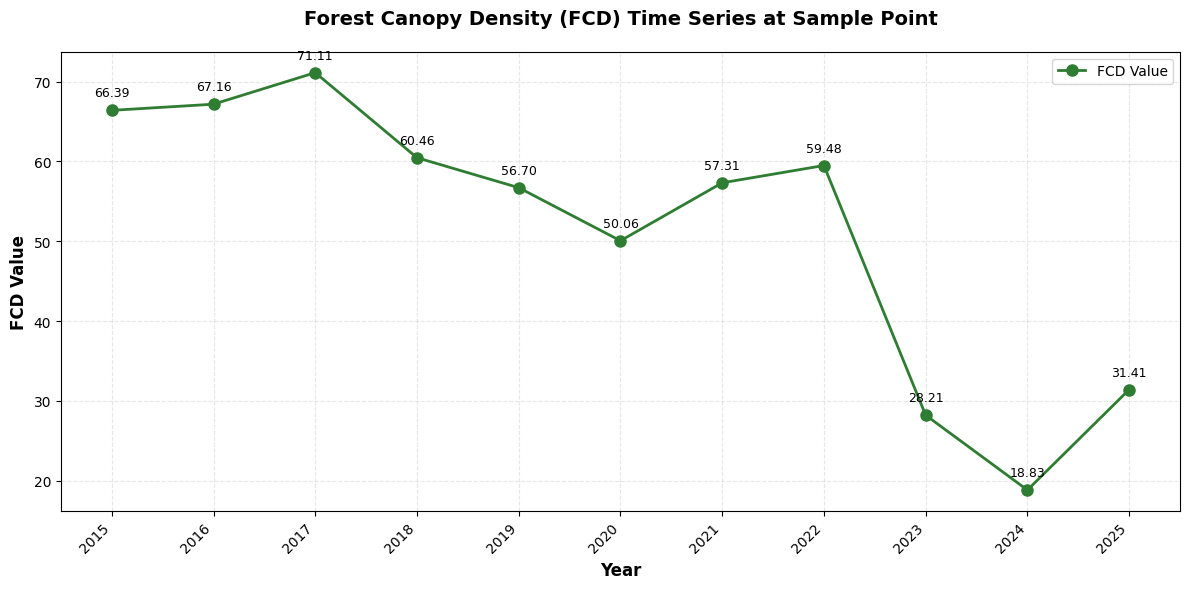


FCD Time Series Summary Statistics
Mean FCD: 51.56
Std FCD: 17.52
Min FCD: 18.83 (Year: 2024)
Max FCD: 71.11 (Year: 2017)
Trend: -34.98 (2015 to 2025)


In [13]:
# Visualize FCD time series
fig, ax = plt.subplots(figsize=(12, 6))

# Plot line chart
ax.plot(fcd_df['year'], fcd_df['fcd_value'], marker='o', linewidth=2, markersize=8, 
        color='#2e7d32', label='FCD Value')

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Labels and title
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('FCD Value', fontsize=12, fontweight='bold')
ax.set_title('Forest Canopy Density (FCD) Time Series at Sample Point', 
             fontsize=14, fontweight='bold', pad=20)

# Format x-axis to show all years
ax.set_xticks(fcd_df['year'])
ax.set_xticklabels(fcd_df['year'], rotation=45, ha='right')

# Add value labels on points
for idx, row in fcd_df.iterrows():
    ax.annotate(f"{row['fcd_value']:.2f}", 
                (row['year'], row['fcd_value']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=9)

# Add legend
ax.legend(loc='best', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("FCD Time Series Summary Statistics")
print("="*50)
print(f"Mean FCD: {fcd_df['fcd_value'].mean():.2f}")
print(f"Std FCD: {fcd_df['fcd_value'].std():.2f}")
print(f"Min FCD: {fcd_df['fcd_value'].min():.2f} (Year: {fcd_df.loc[fcd_df['fcd_value'].idxmin(), 'year']})")
print(f"Max FCD: {fcd_df['fcd_value'].max():.2f} (Year: {fcd_df.loc[fcd_df['fcd_value'].idxmax(), 'year']})")
print(f"Trend: {fcd_df['fcd_value'].iloc[-1] - fcd_df['fcd_value'].iloc[0]:.2f} "
      f"({fcd_df['year'].iloc[0]} to {fcd_df['year'].iloc[-1]})")
